# LDA classifier to predict membership to transcriptional clusters based on DamID signal

Applied to Embryoid Body data.

In [1]:
import numpy as np
import pandas as pd
import h5py
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from collections import defaultdict

import matplotlib.pyplot as plt

# 1. Data loading and pre-processing

## 1.1 Paths & filenames

In [4]:
ANNOFN = '../metadata/EB_all.samplesheet.tsv'
INFOFN = '../metadata/EB_all.data_locations.tsv'
STAT_OUTFN = '../data/FR210226.EB_all.sample_statistics.tsv.gz'

BINSIZE = 10000
MIN_MAP_PER_KB = 1
MIN_MAP = 1 * BINSIZE / 1000

chromosomes = [str(c) for c in range(1,20)] + ['X'] # EXCLUDE Y

## 1.2 Loading metadata

In [5]:
data_locs = pd.read_table(INFOFN)

In [6]:
# load samplesheet
anno = pd.read_table(ANNOFN)
ind = anno.DamID_PASS & (anno.cellcount == 1) & (anno.condition != 'F1ES_serum')
anno = anno.loc[ind, ['runid', 'damid_name', 'celseq_name', 'construct', 'condition', 'seurat_cluster']]

# add sample statistics
stats = pd.read_table(STAT_OUTFN)
anno = anno.merge(stats)

anno = anno.set_index('damid_name')
anno.head()

,runid,celseq_name,construct,condition,seurat_cluster,nTranscripts,nGenes,nERCC,nMito,nAC_Gm,gatc_counts,gatc_counts_somatic,IC_mappability,DamID_PASS,CELseq_PASS
damid_name,,,,,,,,,,,,,,,
KIN5156.index25.DamID2_BC_002,KIN5156,KIN5156.index25.CELseq2_BC_002,Ring1B_full,EB_day07,cluster_1,13168,4364,15,520,313,6185,5695,3.528679,True,True
KIN5156.index25.DamID2_BC_003,KIN5156,KIN5156.index25.CELseq2_BC_003,Ring1B_full,EB_day07,cluster_1,10105,3720,22,443,257,18438,16835,2.622308,True,True
KIN5156.index25.DamID2_BC_004,KIN5156,KIN5156.index25.CELseq2_BC_004,Ring1B_full,EB_day07,cluster_1,8237,3355,15,292,321,3762,3695,5.524841,True,True
KIN5156.index25.DamID2_BC_005,KIN5156,KIN5156.index25.CELseq2_BC_005,Ring1B_full,EB_day07,cluster_5,15201,4895,15,340,291,4030,3512,3.954642,True,True
KIN5156.index25.DamID2_BC_006,KIN5156,KIN5156.index25.CELseq2_BC_006,Ring1B_full,EB_day07,cluster_1,6753,3033,14,351,292,33915,31877,2.107182,True,True


In [7]:
BREWER_PAL = ["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#FFFF33", "#A65628", "#F781BF", "grey"]
brewer_palette = {c: BREWER_PAL[i] for i, c in enumerate(sorted(anno.seurat_cluster.unique()))}

### Visualizing samples per cluster

<AxesSubplot:xlabel='seurat_cluster', ylabel='count'>

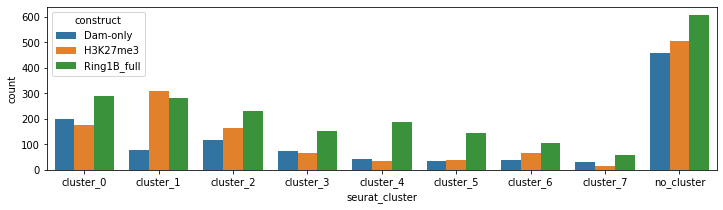

In [8]:
fig, ax = plt.subplots(figsize=(12,3))
to_plot = anno.groupby(['construct', 'seurat_cluster']).size().reset_index().rename(columns={0:'count'})
sns.barplot(x=to_plot['seurat_cluster'], y=to_plot['count'], hue=to_plot['construct'])

## 1.3 Loading single-cell DamID counts

In [9]:
damid_counts = defaultdict(list)
mapab = defaultdict(dict)
sample_names = list()

for runid, runid_anno in anno.groupby(['runid']):
    print(runid)
    fnfmt = data_locs.loc[(data_locs.data_type == 'damid_table') & (data_locs.runid == runid), 'filename'].values[0]

    # loading sample counts
    fn = '../../' + fnfmt.format(runid=runid, genotype='combined_genotypes', binsize=BINSIZE)

    comb_counts = dict()
    with h5py.File(fn, 'r') as f:
        samples = f['sample_names'][:].astype(str)
        keep_samples = np.isin(samples, anno.index.values)
        samples = samples[keep_samples]
        sample_names.append(samples)
        
        for chrom in chromosomes:
            countmatrix = f[chrom][:]
            mapab[chrom] = countmatrix[:,0]
            damid_counts[chrom].append(countmatrix[:,keep_samples])

# concatenating data of different runs
for chrom in tqdm(chromosomes):
    damid_counts[chrom] = np.concatenate(damid_counts[chrom], axis=1)
    
sample_names = np.concatenate(sample_names)
assert all(np.isin(sample_names, anno.index.values))
assert all(np.isin(anno.index.values, sample_names))
anno = anno.loc[sample_names,:]

KIN5156
KIN5434
KIN5578
KIN5599
KIN5600


  0%|          | 0/20 [00:00<?, ?it/s]

## 1.4 Generating sample matrices

In [10]:
damid_matrices = defaultdict(dict)

for construct, df in anno.groupby('construct'):
    sample_ind = (anno.construct == construct).values
    matrix = list()
    
    for c in chromosomes:
        matrix.append(damid_counts[c][:,sample_ind])
        
    matrix = np.concatenate(matrix, axis=0)
    print(construct, sample_ind.sum(), matrix.shape)

    damid_matrices[construct]['raw'] = np.copy(matrix)
    damid_matrices[construct]['anno'] = df.copy()
    
    print(matrix[:5,:5])
    print('-----------------------')

Dam-only 1077 (263174, 1077)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
-----------------------
H3K27me3 1383 (263174, 1383)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
-----------------------
Ring1B_full 2055 (263174, 2055)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
-----------------------


## 1.5 Normalizing raw counts
Perform a depth normalization as follows:

norm = log( raw_counts / depth * 1e4 + 1 )

The depth of a sample is determined as the total number of observed GATC counts on the somatic chromosomes.

In [11]:
chrlens = {c: damid_counts[c].shape[0] for c in chromosomes}
somatic_chr_ind = np.concatenate([np.repeat(c, chrlens[c]) for c in chromosomes]) != 'X'

for construct in damid_matrices:
    
    # determine depth (somatic chroms only)
    depths = damid_matrices[construct]['raw'][somatic_chr_ind,:].sum(axis=0)
    
    # perform lognorm
    countarray = np.copy(damid_matrices[construct]['raw'])
    damid_matrices[construct]['lognorm'] = np.log1p( countarray / depths[None,:] * 1e4)

## 1.6 Determine which bins to include in the analysis
Remove bins that:
- Have less than 10 GATCs (1 GATC per kb)
- Are observed in <1% of samples

In [12]:
# generating bin-filtering indices
m_ind = np.concatenate([mapab[c] for c in chromosomes]) > MIN_MAP # bin is mappable

p_ind = list()
for construct in damid_matrices:
    p = (damid_matrices[construct]['raw'] > 0).sum(axis=1) 
    p_ind.append(p)
p_ind = np.array(p_ind).sum(axis=0) > len(anno)*0.01 # bin is seen in >1% of samples

filt_ind = m_ind & p_ind

In [13]:
filt_ind.mean()

0.9427793019067233

## 1.7 Computing pair-wise correlation distances

This step takes long. If this notebook is run multiple times, it's recommended to save the resulting distance matrices and load them directly in the future.

In [14]:
from sklearn.metrics import pairwise_distances

In [15]:
METRIC = 'correlation'

for construct in damid_matrices:
    print(construct)

    annotmp = damid_matrices[construct]['anno']
    samples = annotmp.index.values
    
    print('Computation of %s distance for %s in progress...' % (METRIC, construct))
    norm_data = damid_matrices[construct]['lognorm'][filt_ind,:]
    dist_values = pairwise_distances(norm_data.T, metric=METRIC, n_jobs=3)
    damid_matrices[construct]['%s_dist' % METRIC] = dist_values
    print('Done!')

Dam-only
Computation of correlation distance for Dam-only in progress...
Done!
H3K27me3
Computation of correlation distance for H3K27me3 in progress...
Done!
Ring1B_full
Computation of correlation distance for Ring1B_full in progress...
Done!


# 2. Build LDA classifier to predict sample labels and test performance

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## 2.1 Select training samples

In [33]:
PROBABILITY_THRESH = 0.5 # probability threshold to accept prediction
TEST_FRAC = 1/3 # fraction of samples with known labels to use as test data (select is made per cluster)

In [34]:
np.random.seed(0)

## select cells for fitting the LDA and cells for testing the results:
for construct in damid_matrices:

    # divide samples in training and testing sets
    annotmp = damid_matrices[construct]['anno'].copy()
    annotmp['lda_set'] = 'train'
    
    # select a number of testing sample per cluster
    for cluster, df in annotmp.groupby('seurat_cluster'):
        
        # A predetermined fraction (TEST_FRAC) of samples belonging to each cluster
        # is used as a test set; samples that do not belong to a cluster ("no_cluster")
        # are all "testing" samples and are excluded from training
        indices = df.index.values
        n = int(np.floor(len(indices)*TEST_FRAC))
        test_ind = np.random.choice(indices, size=n, replace=False)
        if cluster == 'no_cluster':
            annotmp.loc[indices, 'lda_set'] = 'test'
        else:
            annotmp.loc[test_ind, 'lda_set'] = 'test'
    damid_matrices[construct]['anno'] = annotmp
    damid_matrices[construct]['train_samples'] = annotmp[annotmp.lda_set == 'train'].index.values

## 2.2 Train and fit LDA

In [35]:
lda_results = dict()
lda_info = dict()

In [36]:
for construct in damid_matrices:

    annodf = damid_matrices[construct]['anno'].copy()
    
    training_samples = damid_matrices[construct]['train_samples']
    sample2index = {s: i for i, s in enumerate(annodf.index.values)}
    training_ind = np.array([sample2index[s] for s in training_samples]) # indices to select training data from data matrix
    cluster_ids = annodf.loc[training_samples, 'seurat_cluster'].values # known labels for training data
    
    assert not 'no_cluster' in cluster_ids
    
    print(construct)

    # select training data
    training_data = damid_matrices[construct]['correlation_dist'][training_ind,:]
    
    # select all data
    transform_data = damid_matrices[construct]['correlation_dist']

    print(training_data.shape, transform_data.shape)

    # train LDA on training data
    lda_all = LinearDiscriminantAnalysis(n_components=len(np.unique(cluster_ids))-1)
    lda_all.fit(training_data, cluster_ids)

    # make predictions for all data
    data_transformed = lda_all.transform(transform_data)
    
    # store results in dict
    lda_results[construct] = data_transformed
    lda_info[construct] = {
        'explained_variance_ratio': lda_all.explained_variance_ratio_,
        'feature_coef': lda_all.coef_,
        'predicted_cluster': lda_all.predict(transform_data),
        'predicted_cluster_prob': lda_all.predict_proba(transform_data),
        'predicted_cluster_logprob': lda_all.predict_log_proba(transform_data)
    }

Dam-only
(415, 1077) (1077, 1077)
H3K27me3
(588, 1383) (1383, 1383)
Ring1B_full
(967, 2055) (2055, 2055)


## 2.3 Visualize LDA dimensions

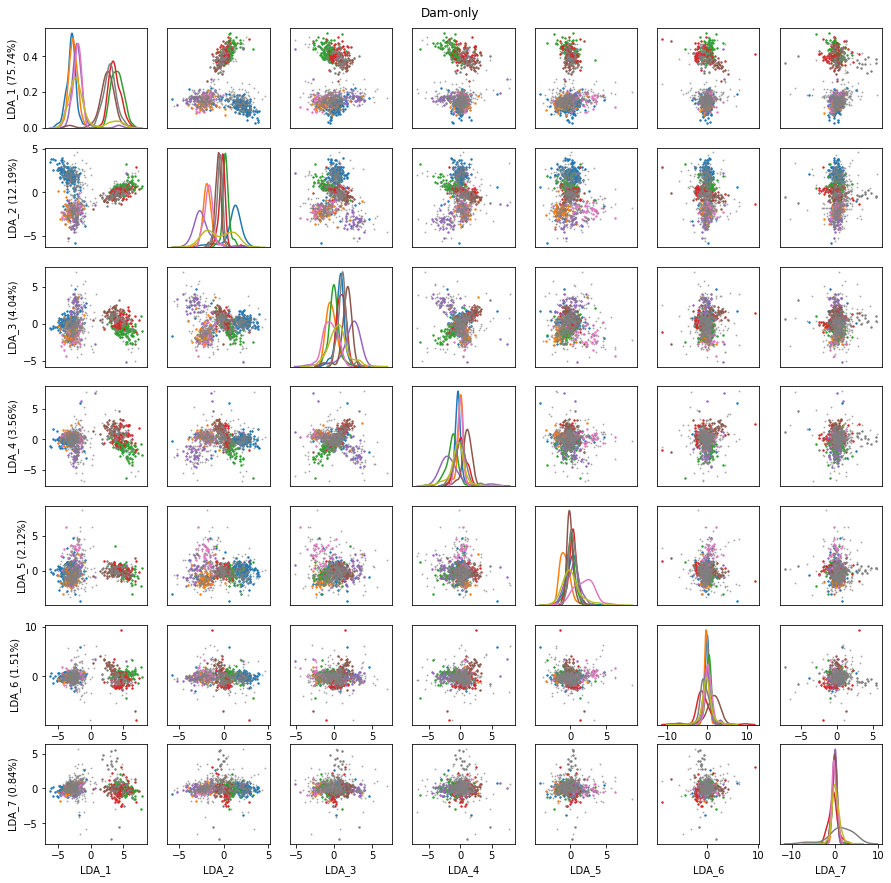

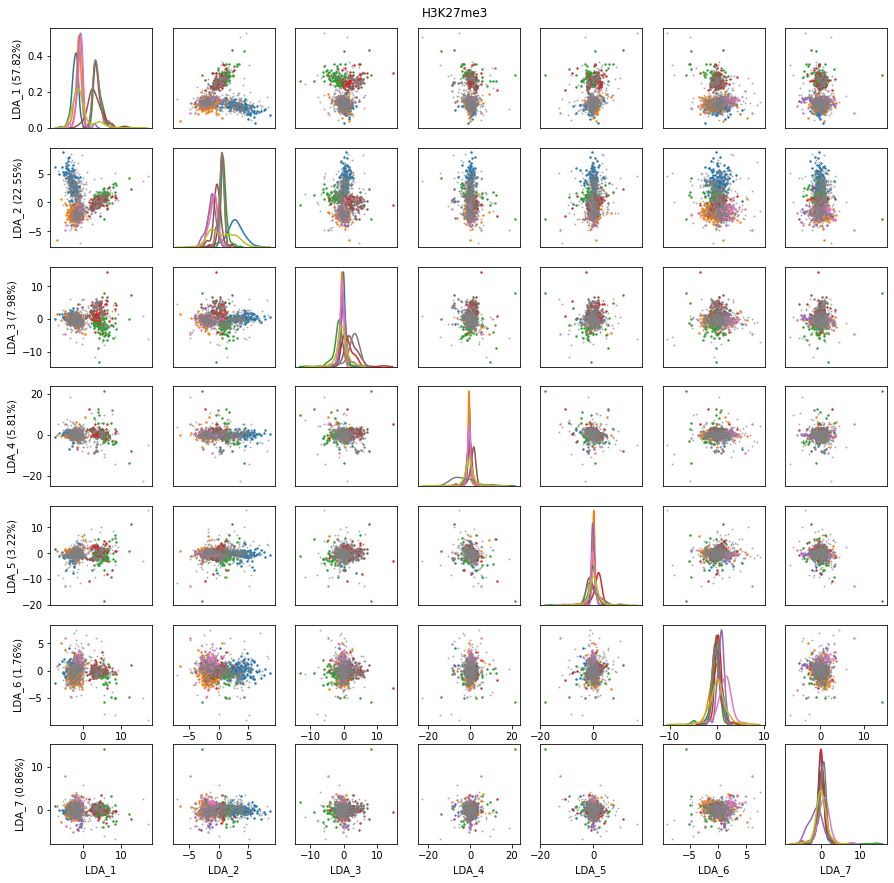

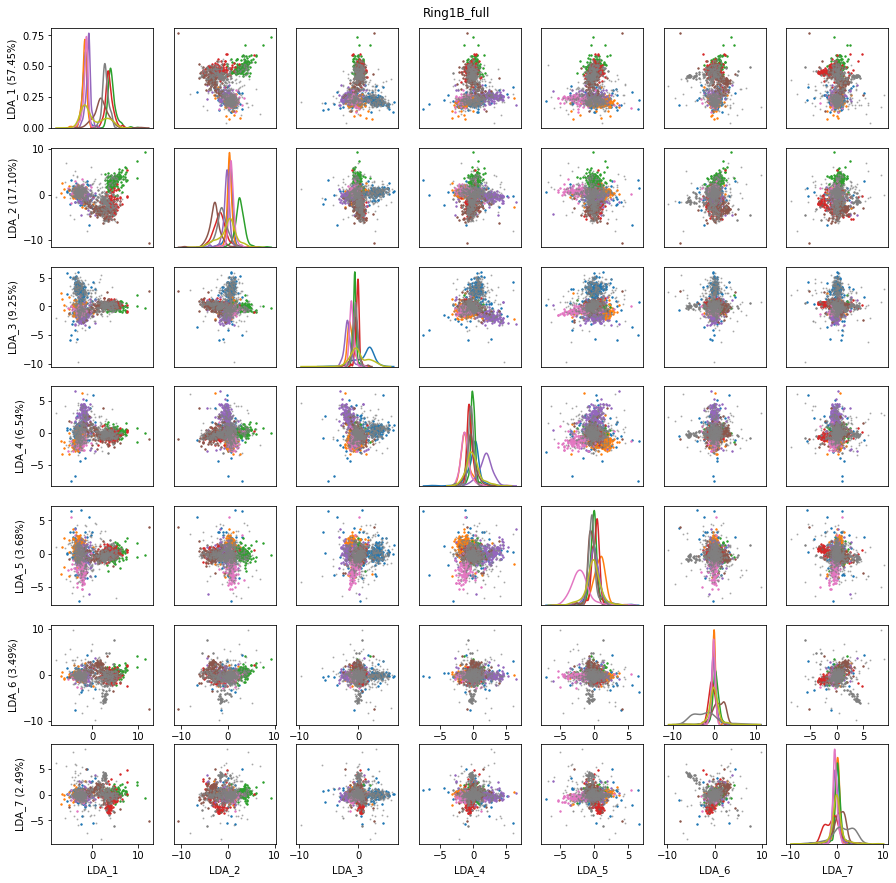

In [37]:
for construct in lda_results:

    # combine dataframe with LDA dimensions with known cluster labels
    to_plot = damid_matrices[construct]['anno'].copy()
    colnames = ['LDA_%d' % i for i in range(1,len(to_plot.seurat_cluster.unique())-1)]
    tmp = pd.DataFrame(lda_results[construct], columns=colnames, index=to_plot.index)
    to_plot = pd.concat([tmp, to_plot[['seurat_cluster']]], axis=1)

    explained_var = lda_info[construct]['explained_variance_ratio']

    nrow = to_plot.shape[1]-1
    fig, axes = plt.subplots(nrow, nrow,figsize=(15,15))
    plt.subplots_adjust(hspace=.2, wspace=.2)
    plt.suptitle(y=0.9, t=construct)

    # plot the relationship between all LDA dimensions
    for i, var1 in enumerate(to_plot.columns[:-1]):
        for j, var2 in enumerate(to_plot.columns[:-1]):
            ax = axes[j,i]

            for cluster, df in to_plot.groupby('seurat_cluster'):
                X = df[var1]
                Y = df[var2]

                if i != j:
                    if cluster == 'no_cluster':
                        ax.scatter(X, Y, s=1, alpha=0.5, c='grey')
                    else:
                        ax.scatter(X, Y, s=2)
                else:
                    sns.kdeplot(X, ax=ax)

            if var1.startswith('LDA') & (j == 5):
                ax.set_xlabel('{} ({:.2f}%)'.format(var1, explained_var[i]*100))
            elif j == (nrow-1):
                ax.set_xlabel(var1)
            else:
                ax.set_xlabel('')
                ax.set_xticks([])
            if var2.startswith('LDA') & (i == 0):
                ax.set_ylabel('{} ({:.2f}%)'.format(var2, explained_var[j]*100))
            elif i == 0:
                ax.set_ylabel(var2)
            else:
                ax.set_ylabel('')
                ax.set_yticks([])
            ax.grid(False)
    plt.show()
    plt.close()

## 2.4 Visualize explained variance per LDA dimension

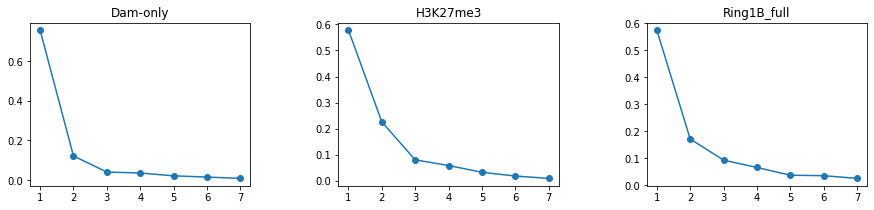

In [38]:
ncol = len(lda_results)

fig, axes = plt.subplots(1, ncol, figsize=(ncol*5, 3))
plt.subplots_adjust(wspace=0.4)

for icol, construct in enumerate(lda_results.keys()):
    ax = axes[icol]
    ax.set_title(construct)


    explained_var = lda_info[construct]['explained_variance_ratio']
    ax.plot(range(1,len(explained_var)+1), explained_var, 'o-')

## 2.5 Visualize confusion matrices

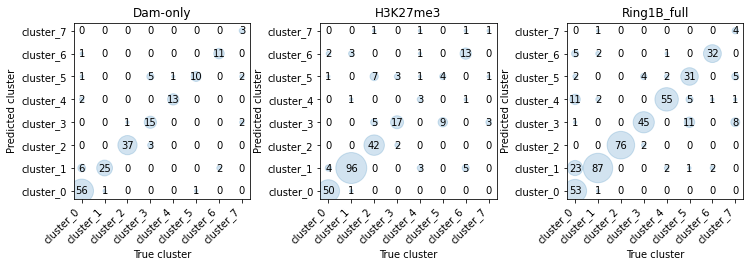

In [41]:
ncol = len(lda_results)

fig, axes = plt.subplots(1, ncol, figsize=(ncol*4, 4))
plt.subplots_adjust(wspace=0.4)

for icol, construct in enumerate(lda_results.keys()):
        
    # combine known cluster labels with predictions
    to_plot = damid_matrices[construct]['anno'].copy()
    all_clusters = sorted(to_plot[to_plot.seurat_cluster != 'no_cluster'].seurat_cluster.unique())

    to_plot['predicted_cluster'] = lda_info[construct]['predicted_cluster']
    to_plot['predicted_cluster_prob'] = lda_info[construct]['predicted_cluster_prob'].max(axis=1)
    
    # only accept predictions that pass the set threshold
    to_plot = to_plot[to_plot.predicted_cluster_prob > PROBABILITY_THRESH]

    # exclude samples used in training
    all_clusters = ['cluster_%d' % c for c in range(8)]
    to_plot = to_plot[(to_plot.lda_set == 'test') & (to_plot.seurat_cluster != 'no_cluster')].copy()
    to_plot['seurat_cluser'] = pd.Categorical(to_plot['seurat_cluster'], categories=all_clusters)
    to_plot['predicted_cluser'] = pd.Categorical(to_plot['predicted_cluster'], categories=all_clusters)
    
    # compute the number of samples attributed to each cluster
    to_plot = to_plot.groupby(['seurat_cluster', 'predicted_cluster']).size().unstack().fillna(0).astype(int).stack().reset_index()
    to_plot = to_plot.rename(columns={0: 'count'})

    # format dataframe
    to_plot['count'] = to_plot['count'].astype(int)
    to_plot['text'] = to_plot['count'].astype(str)
    to_plot = to_plot.sort_values(by=['seurat_cluster', 'predicted_cluster']).reset_index(drop=True)
    
    # plot results
    ax = axes[icol]
    tmp = {c: i for i, c in enumerate(all_clusters)}
    x = [tmp[c] for c in to_plot['seurat_cluster']]
    y = [tmp[c] for c in to_plot['predicted_cluster']]
    ax.scatter(x=x, y=y, s=to_plot['count']*10, alpha=0.2)

    for i, row in to_plot.iterrows():
        ax.text(x[i], y[i], s=row['text'], ha='center', va='center')


    ax.set_xticks(range(len(all_clusters)))
    ax.set_xticklabels(all_clusters)
    ax.set_yticks(range(len(all_clusters)))
    ax.set_yticklabels(all_clusters)
    ax.set_title(construct)
    ax.set_aspect('equal')
    ax.set_xlabel('True cluster')
    ax.set_ylabel('Predicted cluster')

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')

# 3. Compute Final LDA - Predict cluster labels

Now that the performance has been tested, we can retrain the LDA using all samples with known cluster labels for training. This will likely still improve the performance for the final predictions.

## 3.1 Select training samples

Training samples are all samples with known cluster labels.

In [42]:
np.random.seed(0)

## select cells for fitting the LDA and cells for testing the results:
for construct in damid_matrices:

    annotmp = damid_matrices[construct]['anno'].copy()
    annotmp['lda_set'] = 'train'
    annotmp.loc[annotmp.seurat_cluster == 'no_cluster', 'lda_set'] = 'test'
    
    ## select train samples
    train_samples = annotmp[annotmp.lda_set == 'train'].index.values
    damid_matrices[construct]['final_train_samples'] = train_samples

## 3.2 Train and fit data

In [43]:
final_lda_results = dict()
final_lda_info = dict()

In [44]:
for construct in damid_matrices:

    print(construct)
    annodf = damid_matrices[construct]['anno'].copy()
    
    training_samples = damid_matrices[construct]['final_train_samples']
    sample2index = {s: i for i, s in enumerate(annodf.index.values)}
    training_ind = np.array([sample2index[s] for s in training_samples])  # indices to select training data from data matrix
    cluster_ids = annodf.loc[training_samples, 'seurat_cluster'].values # known labels for training data
    assert not 'no_cluster' in cluster_ids
        
    # select training data
    training_data = damid_matrices[construct]['correlation_dist'][training_ind,:]
    
    # select all data
    transform_data = damid_matrices[construct]['correlation_dist']

    # train LDA on training data
    lda_all = LinearDiscriminantAnalysis(n_components=len(np.unique(cluster_ids))-1)
    lda_all.fit(training_data, cluster_ids)

    # make predictions for all data
    data_transformed = lda_all.transform(transform_data)
    
    # store results in dict
    final_lda_results[construct] = data_transformed
    final_lda_info[construct] = {
        'explained_variance_ratio': lda_all.explained_variance_ratio_,
        'feature_coef': lda_all.coef_,
        'predicted_cluster': lda_all.predict(transform_data),
        'predicted_cluster_prob': lda_all.predict_proba(transform_data),
        'predicted_cluster_logprob': lda_all.predict_log_proba(transform_data)
    }

Dam-only
H3K27me3
Ring1B_full


## 3.3 Visualized number of predicted samples per cluster

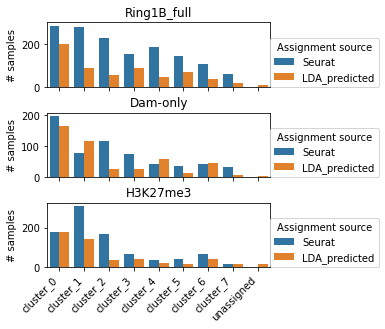

In [45]:
nrow = len(anno.construct.unique())
fig, axes = plt.subplots(nrow, 1, figsize=(4, 1.5*nrow), sharex=True)
plt.subplots_adjust(hspace=0.4)

all_clusters = sorted(anno[anno.seurat_cluster != 'no_cluster'].seurat_cluster.unique())

for irow, construct in enumerate(anno.construct.unique()):
    annotmp = damid_matrices[construct]['anno'].copy()
    annotmp['predicted_cluster'] = final_lda_info[construct]['predicted_cluster']
    annotmp['predicted_cluster_prob'] = final_lda_info[construct]['predicted_cluster_prob'].max(axis=1)
    annotmp.loc[annotmp.predicted_cluster_prob < 0.5, 'predicted_cluster'] = 'unassigned'
    
    annotmp['assignment'] = annotmp.seurat_cluster.copy()
    annotmp['type'] = 'Seurat'
    ind = anno.seurat_cluster == 'no_cluster'
    annotmp.loc[ind, 'assignment'] = annotmp.loc[ind, 'predicted_cluster']
    annotmp.loc[ind, 'type'] = 'LDA_predicted'
    
    ax = axes[irow]
    
    to_plot = annotmp.groupby(['assignment', 'type']).size().reset_index().rename(columns={0: 'count'})
    sns.barplot(x=to_plot['assignment'], y=to_plot['count'], hue=to_plot['type'], ax=ax, hue_order=['Seurat', 'LDA_predicted'])
    ax.set_title(construct)
    
    ax.set_xlabel('')
    ax.legend(loc=(1,0), title='Assignment source')
    ax.set_ylabel('# samples')
    
for tick in axes[irow].get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')